In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,Activation,BatchNormalization,Add,Multiply,Concatenate,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import datetime
import pandas as pd
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_files=['/content/drive/MyDrive/DataScience/patches-train/train/'+filename for filename in os.listdir('/content/drive/MyDrive/DataScience/patches-train/train/')]
test_files=['/content/drive/MyDrive/DataScience/patches-test/test/'+filename for filename in os.listdir('/content/drive/MyDrive/DataScience/patches-test/test/')]

In [ ]:
def _parse_function(filename):
    '''This function performs adding noise to the image given by Dataset'''
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.

    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

In [ ]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,50] 

#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
iterator = iter(train_dataset)
a, b = iterator.get_next()

print('Shape of single batch of x : ',a.shape)
print('Shape of single batch of y : ',b.shape)

Shape of single batch of x :  (64, 40, 40, 3)
Shape of single batch of y :  (64, 40, 40, 3)


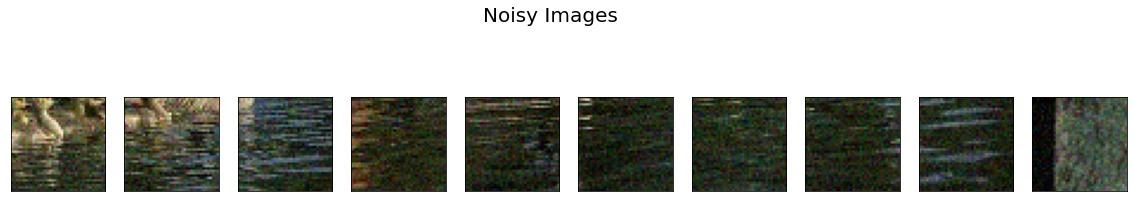

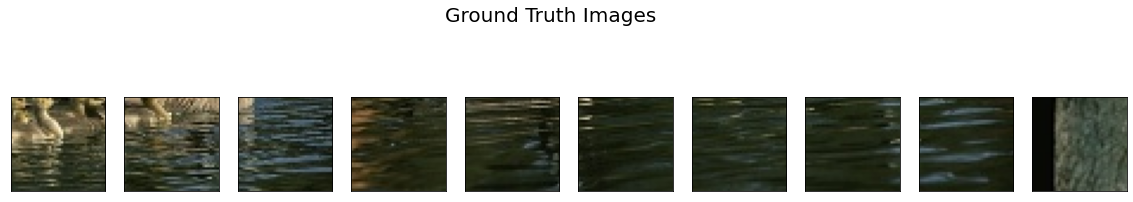

In [ ]:
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(a[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Noisy Images',fontsize=20)
plt.show()
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(b[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Ground Truth Images',fontsize=20)
plt.show()

In [ ]:
def get_patches(file_name,patch_size,crop_sizes):
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: 
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] 
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  image=np.zeros(image_shape) 
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] 
      p+=1
  return np.array(image)

def predict_fun(model,image_path,noise_level=30):
  patches=get_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


def PSNR(gt, image, max_value=1):
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [ ]:
def EAM(input):

  x=Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
  x=Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(x)

  y=Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)
  y=Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(y)

  z=Concatenate(axis=-1)([x,y])
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  add_1=Add()([z, input])

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_1)
  z=Conv2D(64, (3,3),padding='same')(z)
  add_2=Add()([z,add_1])
  add_2 = Activation('relu')(add_2)

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (1,1),padding='same')(z)
  add_3=Add()([z,add_2])
  add_3 = Activation('relu')(add_3)

  z = GlobalAveragePooling2D()(add_3)
  z = tf.expand_dims(z,1)
  z = tf.expand_dims(z,1)
  z=Conv2D(4, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (3,3),padding='same',activation='sigmoid')(z)
  mul=Multiply()([z, add_3])

  return mul

In [ ]:
def RIDNET():

  input = Input((40, 40, 3),name='input')
  feat_extraction =Conv2D(64, (3,3),padding='same')(input)
  eam_1=EAM(feat_extraction)
  eam_2=EAM(eam_1)
  eam_3=EAM(eam_2)
  eam_4=EAM(eam_3)
  x=Conv2D(3, (3,3),padding='same')(eam_4)
  add_2=Add()([x, input])
  
  model=Model(input,add_2)

  return model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(6908)
ridnet = RIDNET()

In [ ]:
ridnet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanAbsoluteError())

In [ ]:
ridnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 40, 40, 64)   1792        ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 40, 40, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 40, 40, 64)   36928       ['conv2d[0][0]']                 
                                                                                              

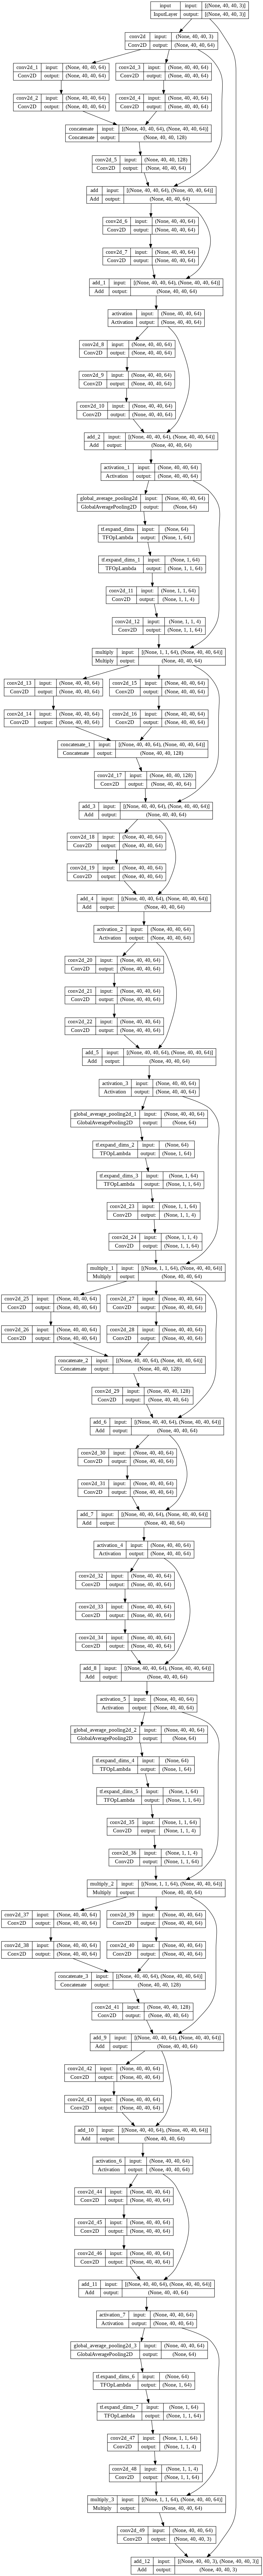

In [ ]:
plot_model(ridnet,show_shapes=True,to_file='ridnet.png')

In [ ]:
def scheduler(epoch,lr):
  return lr*0.9

In [ ]:
checkpoint_path = "/content/drive/MyDrive/DataScience/ridnet.h5" 
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) # To save the model if the metric is improved

# Tensorbaord 
logdir = os.path.join("/content/drive/MyDrive/DataScience/logs_ridnet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # Directory for storing the logs that are required for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [cp_callback,tensorboard_callback,lrScheduler]
ridnet.fit( train_dataset,shuffle=True,epochs=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 1/10
273/273 [==============================] - 13052s 48s/step - loss: 0.0300 - val_loss: 0.0386 - lr: 9.0000e-04
Epoch 2/10
273/273 [==============================] - 125s 459ms/step - loss: 0.0216 - val_loss: 0.0354 - lr: 8.1000e-04
Epoch 3/10
273/273 [==============================] - 125s 459ms/step - loss: 0.0198 - val_loss: 0.0353 - lr: 7.2900e-04
Epoch 4/10
273/273 [==============================] - 126s 460ms/step - loss: 0.0193 - val_loss: 0.0344 - lr: 6.5610e-04
Epoch 5/10
273/273 [==============================] - 126s 460ms/step - loss: 0.0189 - val_loss: 0.0343 - lr: 5.9049e-04
Epoch 6/10
273/273 [==============================] - 125s 460ms/step - loss: 0.0186 - val_loss: 0.0343 - lr: 5.3144e-04
Epoch 7/10
273/273 [==============================] - 125s 460ms/step - loss: 0.0184 - val_loss: 0.0340 - lr: 4.7830e-04
Epoch 8/10
273/273 [==============================] - 125s 459ms/step - loss: 0.0182 - val_loss: 0.0339 - lr: 4.3047e-04
Epoch 9/10
273/273 [============

In [ ]:
ridnet.fit( train_dataset,shuffle=True,epochs=30,initial_epoch=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 11/30
273/273 [==============================] - 125s 459ms/step - loss: 0.0177 - val_loss: 0.0338 - lr: 3.1381e-04
Epoch 12/30
273/273 [==============================] - 125s 459ms/step - loss: 0.0176 - val_loss: 0.0342 - lr: 2.8243e-04
Epoch 13/30
273/273 [==============================] - 125s 460ms/step - loss: 0.0175 - val_loss: 0.0344 - lr: 2.5419e-04
Epoch 14/30
273/273 [==============================] - 125s 459ms/step - loss: 0.0174 - val_loss: 0.0346 - lr: 2.2877e-04
Epoch 15/30
273/273 [==============================] - 125s 459ms/step - loss: 0.0174 - val_loss: 0.0343 - lr: 2.0589e-04
Epoch 16/30
273/273 [==============================] - 125s 459ms/step - loss: 0.0173 - val_loss: 0.0343 - lr: 1.8530e-04
Epoch 17/30
273/273 [==============================] - 125s 459ms/step - loss: 0.0172 - val_loss: 0.0339 - lr: 1.6677e-04
Epoch 18/30
273/273 [==============================] - 125s 460ms/step - loss: 0.0172 - val_loss: 0.0338 - lr: 1.5009e-04
Epoch 19/30
273/273 [===

3/3 [==============================] - 0s 68ms/step
PSNR of Noisy Image :  14.948496389212345
PSNR of Denoised Image :  19.24019093848541


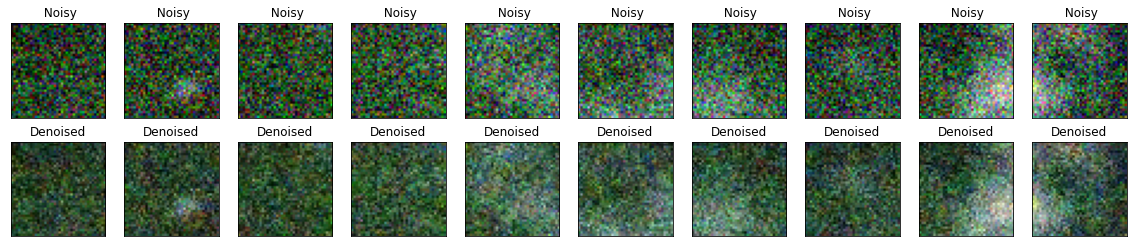

In [ ]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(ridnet,'/content/drive/MyDrive/DataScience/test/247003.jpg',noise_level=50)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

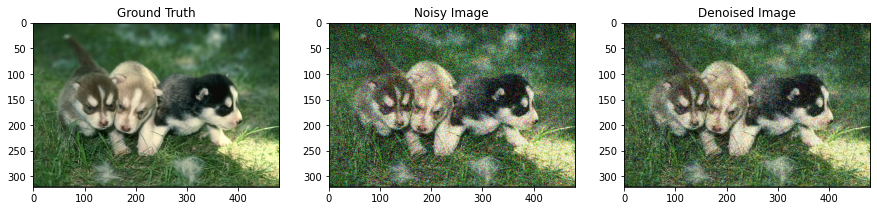

In [ ]:
plot_predictions(ground_truth,noisy_image,denoised_image)

In [ ]:
model_res=Model(ridnet.input,ridnet.get_layer('conv2d_49').output)

In [ ]:
patches_noisy,denoised_patches,ground_truth,noisy_image,residual_image=predict_fun(model_res,'/content/drive/MyDrive/DataScience/test/247003.jpg',noise_level=25)

3/3 [==============================] - 1s 67ms/step


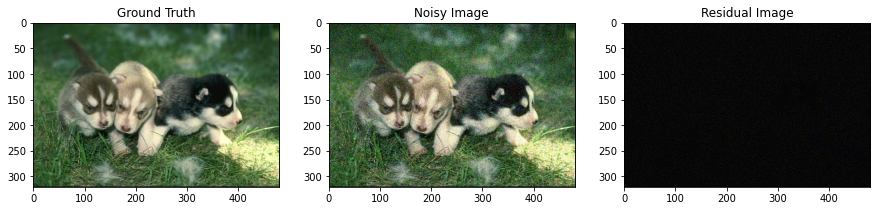

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(ground_truth)
axs[0].title.set_text('Ground Truth')
axs[1].imshow(noisy_image)
axs[1].title.set_text('Noisy Image')
axs[2].imshow(residual_image)
axs[2].title.set_text('Residual Image')
plt.show()